## Import file and required libraries

In [436]:
%reset
import zipfile
import os
from tensorflow import keras

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [437]:
zip_train = zipfile.ZipFile('/content/Image set 1.zip', 'r') #Opens the zip file in read mode
zip_train.extractall('/content') #Extracts the files into the /tmp folder
zip_train.close()

zip_train = zipfile.ZipFile('/content/Image set 2.zip', 'r') #Opens the zip file in read mode
zip_train.extractall('/content') #Extracts the files into the /tmp folder
zip_train.close()

The data augmentation parameters have to be commented out once training is complete as they (for some reason) apply to all ImageDataGenerators

In [438]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagenz = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    shear_range=0.01,
    width_shift_range=0,
    height_shift_range=0,
    rotation_range=360,
    fill_mode='nearest'
    )


train_ds = datagenz.flow_from_directory(
  './Image set 1/train',
  target_size=(64, 64),
  shuffle=True,
  batch_size=16)

valid_ds = datagenz.flow_from_directory(
  './Image set 1/val',
  target_size=(64, 64),
  #shuffle=True,
  batch_size=16)

train2_ds = datagenz.flow_from_directory(
  './Image set 2/training',
  target_size=(64, 64),
  shuffle=True,
  batch_size=16)

valid2_ds = datagenz.flow_from_directory(
  './Image set 2/val',
  target_size=(64, 64),
  #shuffle=True,
  batch_size=16)

Found 1320 images belonging to 4 classes.
Found 486 images belonging to 4 classes.
Found 3027 images belonging to 10 classes.
Found 1214 images belonging to 10 classes.


#Create and train model

## Create the model

### A resnet:

In [536]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from keras.applications.vgg16 import VGG16

numCat = 10 #Should be 4 or 10, depends on the model being used

input_img = Input(shape=(64,64,3))
output1 = Conv2D(16, (3, 3), activation='relu')(input_img)
for i in range(10):
    output2 = Conv2D(16, (3, 3), padding = 'same', activation='relu')(output1)
    output2 = BatchNormalization()(output2)
    output2 = Dropout(0.3)(output2)
    output2 = add([output1, output2])
    output1 = output2
output3 = Flatten()(output2)
output4 = Dense(units = 16, activation = 'relu')(output3)
output5 = Dense(units = 16, activation = 'relu')(output4)
output6a = Dense(units = 16, activation = 'relu')(output5)
output6 = Dense(units = numCat, activation = 'softmax')(output6a)
model = Model(inputs=input_img, outputs=output6)
print(model.summary())

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_134 (Conv2D)         (None, 62, 62, 16)           448       ['input_15[0][0]']            
                                                                                                  
 conv2d_135 (Conv2D)         (None, 62, 62, 16)           2320      ['conv2d_134[0][0]']          
                                                                                                  
 batch_normalization_80 (Ba  (None, 62, 62, 16)           64        ['conv2d_135[0][0]']          
 tchNormalization)                                                                         

## Compile the model

In [440]:
import tensorflow as tf
model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [441]:
#print(model.summary())

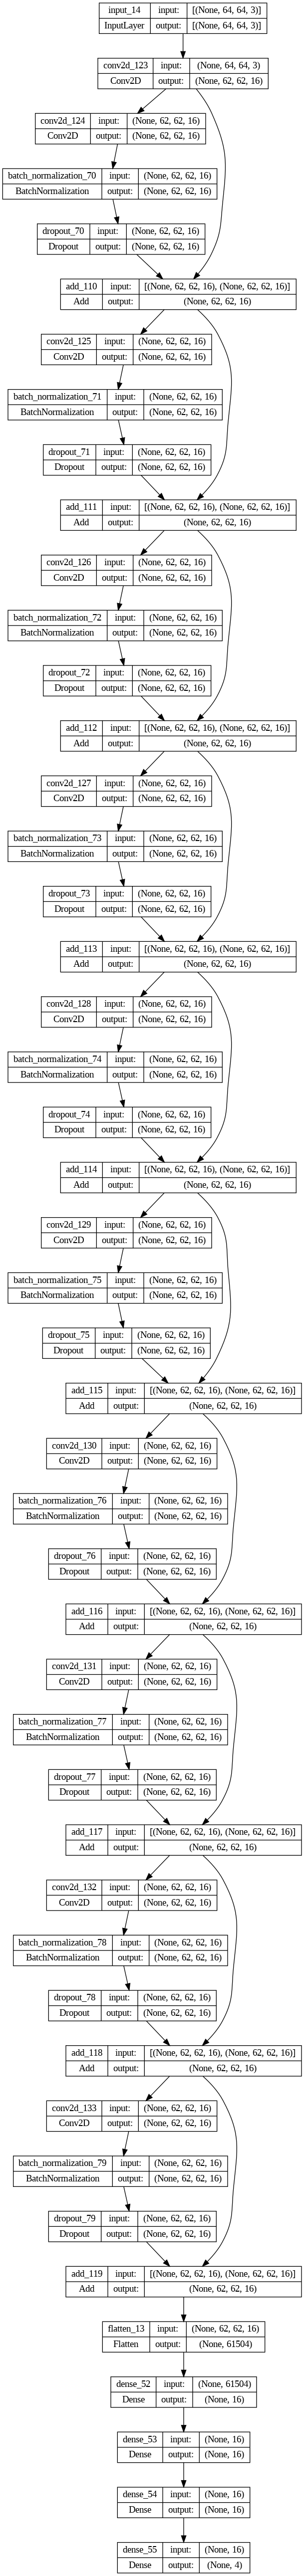

In [442]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

## Create checkpoints for the model

In [443]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callback_a = ModelCheckpoint(filepath = 'my_best_model.hdf5', monitor='val_accuracy', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_accuracy', mode='max', patience=100, verbose=1, restore_best_weights= True)

In [444]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

## Train the model

In [445]:
history = model.fit(train_ds, epochs=10000, validation_data=valid_ds, callbacks = [callback_a, callback_b, cb])

Epoch 1/10000
83/83 [==============================] - ETA: 0s - loss: 1.3500 - accuracy: 0.5508
Epoch 1: val_accuracy improved from -inf to 0.18519, saving model to my_best_model.hdf5
83/83 [==============================] - 10s 64ms/step - loss: 1.3500 - accuracy: 0.5508 - val_loss: 3.0851 - val_accuracy: 0.1852
Epoch 2/10000
82/83 [============================>.] - ETA: 0s - loss: 0.9184 - accuracy: 0.6679
Epoch 2: val_accuracy did not improve from 0.18519
83/83 [==============================] - 4s 46ms/step - loss: 0.9177 - accuracy: 0.6689 - val_loss: 13.6428 - val_accuracy: 0.1317
Epoch 3/10000
61/83 [=====================>........] - ETA: 0s - loss: 0.8773 - accuracy: 0.6715

KeyboardInterrupt: 

In [ ]:
import shutil
shutil.copy('my_best_model.hdf5', '/content/drive/MyDrive')

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
print("Training took: ", sum(cb.logs), " seconds")

#Testing

##Generate test image (3x3 grid of images that will be split)

Found 188 images belonging to 4 classes.
Found 498 images belonging to 10 classes.
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


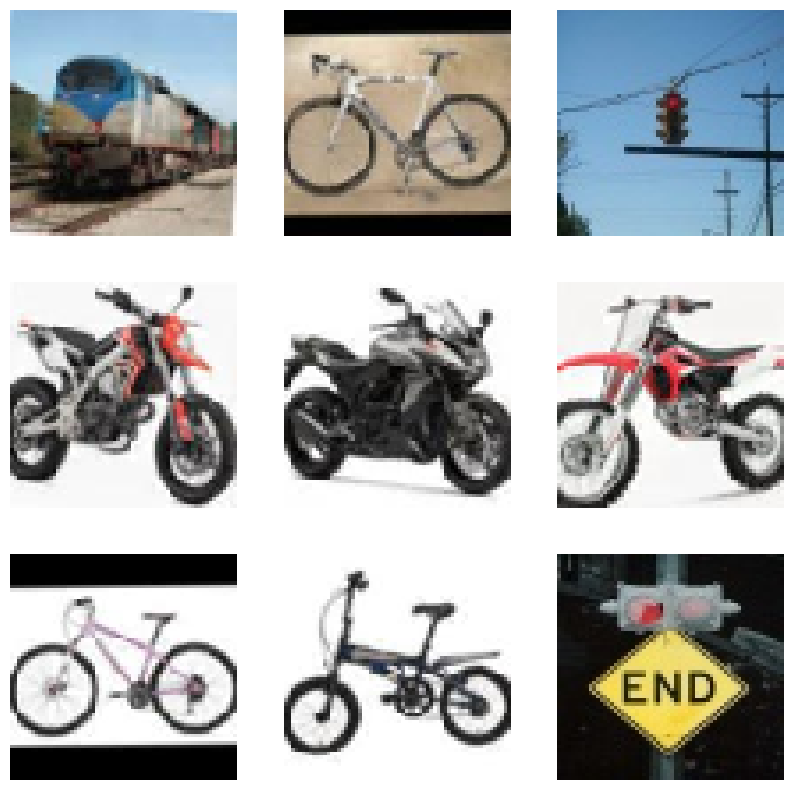

In [660]:
import pandas as pd

getTest = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None
)

test_ds = getTest.flow_from_directory(
  './Image set 1/test',
  target_size=(64, 64),
  shuffle=True,
  batch_size=16)

test_ds2 = getTest.flow_from_directory(
  './Image set 2/test',
  target_size=(64, 64),
  shuffle=True,
  batch_size=16)


image_batch, label_batch = next(iter(test_ds2))

labelsz = []

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  label = label_batch[i]
  labelsz.append(label.argmax())
  print(label)
  #plt.title(class_names[label])
  plt.axis("off")

plt.savefig('test.png', bbox_inches='tight')

##Crop test image

In [661]:
timg = "/content/test.png"

-1

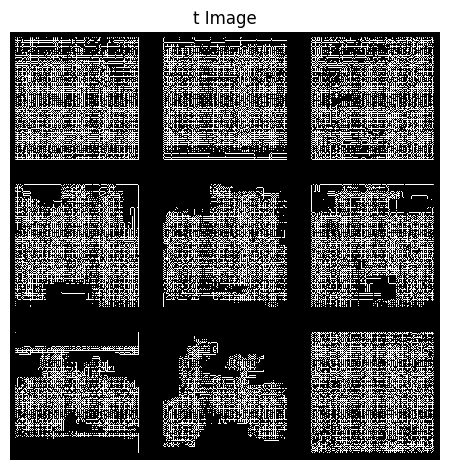

In [674]:
import cv2
import numpy as np
import skimage
img = cv2.imread(timg)

skimage.io.imshow(img)
plt.title('Original Image')
plt.axis('off')

new_img = cv2.Canny(img, 0, 600)
skimage.io.imshow(new_img)
plt.title('1 Image')
plt.axis('off')

blurred = cv2.blur(new_img, (3,3))
canny = cv2.Canny(blurred, 50, 200)

## find the non-zero min-max coords of canny
pts = np.argwhere(canny>0)
y1,x1 = pts.min(axis=0)
y2,x2 = pts.max(axis=0)

## crop the region
cropped = new_img[y1:y2, x1:x2]
cv2.imwrite("cropped.png", cropped)

tagged = cv2.rectangle(new_img.copy(), (x1,y1), (x2,y2), (0,255,0), 3, cv2.LINE_AA)
skimage.io.imshow(tagged)
plt.title('t Image')
plt.axis('off')
cv2.waitKey()

True

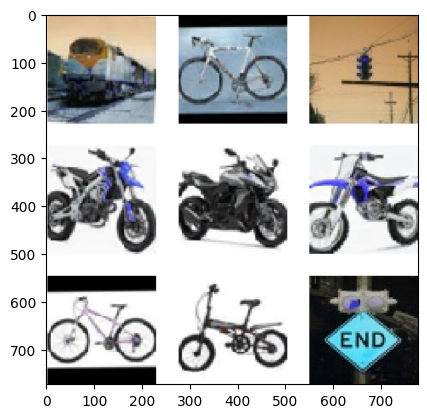

In [675]:
image = cv2.imread(timg)
print()
y = y1
x = x1
h=x2
w=y2
crop_image = image[x:w, y:h]
plt.imshow(crop_image)
cv2.imwrite("croppedt.png", crop_image)

##Split test image into individual images

In [676]:
import cv2,time

img = cv2.imread('/content/croppedt.png')
img2 = img

height, width, channels = img.shape
# Number of pieces Horizontally
W_SIZE  = 3
# Number of pieces Vertically to each Horizontal
H_SIZE = 3
if not os.path.exists('/content/Output Images'):
    os.makedirs('/content/Output Images')
    if not os.path.exists('/content/Output Images/a'):
      os.makedirs('/content/Output Images/a')

for ih in range(H_SIZE ):
   for iw in range(W_SIZE ):

      x = width/W_SIZE * iw
      y = height/H_SIZE * ih
      h = (height / H_SIZE)
      w = (width / W_SIZE )
      print(x,y,h,w)
      img = img[int(y):int(y+h), int(x):int(x+w)]
      NAME = str(time.time())
      cv2.imwrite("Output Images/a/" + str(ih)+str(iw) +  ".png",img)
      img = img2

0.0 0.0 257.6666666666667 259.0
259.0 0.0 257.6666666666667 259.0
518.0 0.0 257.6666666666667 259.0
0.0 257.6666666666667 257.6666666666667 259.0
259.0 257.6666666666667 257.6666666666667 259.0
518.0 257.6666666666667 257.6666666666667 259.0
0.0 515.3333333333334 257.6666666666667 259.0
259.0 515.3333333333334 257.6666666666667 259.0
518.0 515.3333333333334 257.6666666666667 259.0


###Test the test images

In [677]:
print(labelsz)

[8, 1, 7, 4, 4, 4, 1, 1, 7]


In [678]:
import shutil
#shutil.rmtree('./Output Images/')

In [679]:
import tensorflow as tf
model.load_weights('/content/10 classes model 2 trained.hdf5')
model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])

class_a = []

a_ds = getTest.flow_from_directory(
  './Output Images/',
  #labels=labelsz,
  target_size=(64, 64),
  shuffle=False,
  batch_size=16)




test_a = model.predict(a_ds, verbose=1)
class_a = test_a.argmax(axis=-1)
#num = [0,0,0,0,0,0,0,0,0]
#for i in class_a:
  #num[i] = num[i]+1
#print(num)
#print(class_a[0])

Found 9 images belonging to 2 classes.
1/1 [==============================] - 0s 404ms/step


###Get the image the user is looking for

In [680]:
from ast import literal_eval
with open('Labels 2.txt') as f:
    mainlist = [list(literal_eval(line)) for line in f]

#print(mainlist[0][0])

In [681]:
import random
test = 1 #If test equals 1, testing is being done and thus will generate a random number instead of asking for input

if test == 1:
  target = random.randint(0, 10)
else:
  inp = input('What object are you looking for?')
  target = -1
  size = 4

  for i in range(len(mainlist[0])):
    if inp.lower() == mainlist[0][i]:
      target = i

  if target == -1:
    print("Error! Not a valid target (Please refer to the Labels text file corresponding to the size model you are using.)")

print("Target: ", target)

Target:  0


###Print the images that match what the user is looking for

The images that match the category you are looking for are as follows:


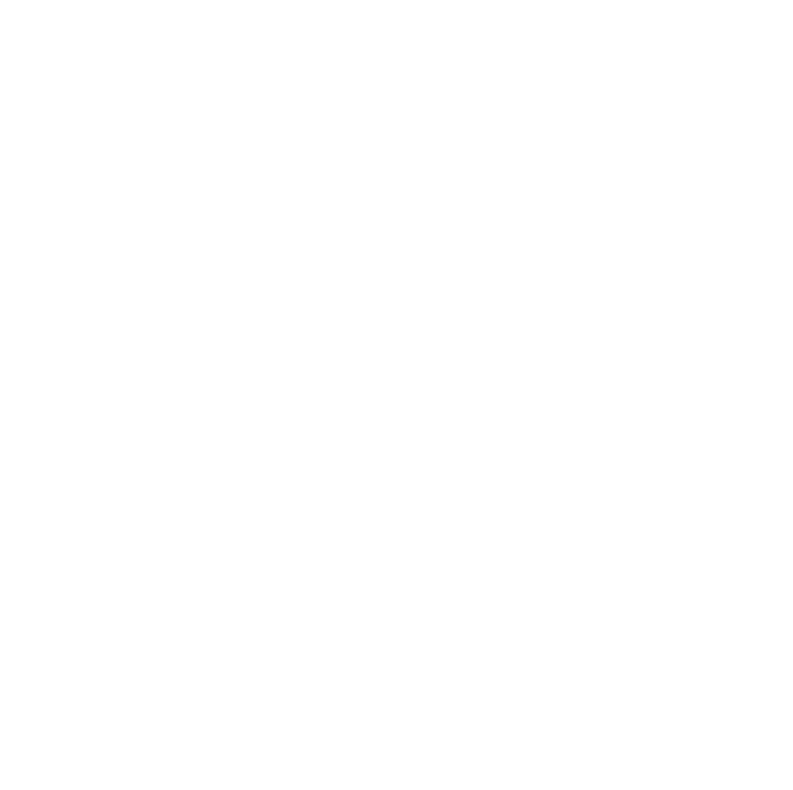

In [682]:
import numpy as np
empty = np.zeros([64,64,3],dtype=np.uint8)
empty.fill(255)

print("The images that match the category you are looking for are as follows:")
plt.figure(figsize=(10, 10))
image_batch, label_batch = next(iter(a_ds))

for i in range(9):

  ax = plt.subplot(3, 3, i + 1)
  if class_a[i] == target:
    plt.imshow(image_batch[i])
  else:
    plt.imshow(empty)
  plt.axis("off")